In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.9 MB/s eta 0:00:00


In [3]:
root_dir = '/gdrive/MyDrive/NLP/10-2. Discourse Analysis'

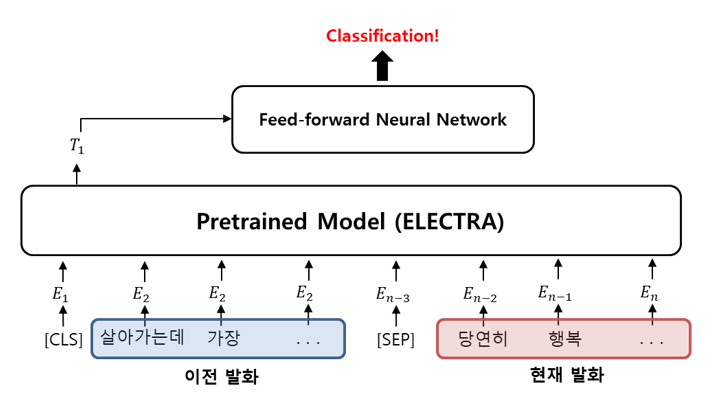

In [4]:
import os
from IPython.display import Image
Image(os.path.join(root_dir, "DiscourseAnalysis.PNG"))

In [5]:
import torch.nn as nn
from transformers import ElectraPreTrainedModel, ElectraModel

class ElectraForSequenceClassification(ElectraPreTrainedModel):
    def __init__(self, config): # 생성자 오버라이딩
        super(ElectraForSequenceClassification, self).__init__(config)

        # Electra 모델
        self.electra = ElectraModel(config)

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels #FNN위에 얹어
        self.hidden_size = config.hidden_size #ELECTRA에 히든사이즈
        #성능 개선 부분 1
        self.output_layer = nn.Sequential(
        nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=self.hidden_size, out_features=self.num_labels))

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        #이전인자 현재인자 구분 좋을 듯!
        # electra_output : (batch_size, max_length, hidden_size)
        electra_output = outputs[0]

        # cls_vector : (batch_size, hidden_size)
        cls_vector = electra_output[:, 0, :] #CLS 가져오기

        # outputs : (batch_size, num_labels)
        outputs = self.output_layer(cls_vector) #Linnear = CNS를 FNN에 올려서 num만큼 출력

        return outputs


In [6]:

import torch
import numpy as np
import re
from tqdm import tqdm

def load_label_vocab(label_file):
    label2idx = {}
    idx2label = {}
    with open(label_file,'r',encoding='utf8') as infile:
        for line in infile:
            line = line.strip()
            label2idx[line] = len(label2idx)
            idx2label[len(idx2label)] = line
    return label2idx, idx2label

def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as infile:
      datas = []
      for line in tqdm(infile, desc="read_data"):
          # 입력 데이터를 \t을 기준으로 분리
          pieces = line.strip().split("\t") # 0 - 이전, 1 - 현재, 2- label 여기서 앞에 두개를 봐도 되겠다.
          last_utterance, cur_utterance, label = pieces[0], pieces[1], pieces[2]
          datas.append((last_utterance, cur_utterance, label))
    return datas

def convert_data2feature(datas, max_length, tokenizer, label2idx):
    input_ids_features, attention_mask_features, token_type_ids_features, label_id_features = [], [], [], []

    for last_utterance, cur_utterance, label in tqdm(datas, desc="convert_data2feature"):

        tokenized_last_utterance = tokenizer.tokenize(last_utterance)
        tokenized_cur_utterance = tokenizer.tokenize(cur_utterance)
        tok_len = []

        tokens = [tokenizer.cls_token]
        tokens += tokenized_last_utterance
        tokens += [tokenizer.sep_token]
        tokens += tokenized_cur_utterance
        tokens += [tokenizer.sep_token]
        
        tok_len.append(len([tokenizer.cls_token]))
        tok_len.append(len(tokenized_last_utterance))
        tok_len.append(len([tokenizer.sep_token]))
        tok_len.append(len(tokenized_cur_utterance))
        tok_len.append(len([tokenizer.sep_token]))
        

#input_ids :  [2, 6470, 4112, 6395, 9375, 3, 2270, 6470, 4007, 21160, 2967, 3249, 7218, 6243, 20653, 35, 3]

        #########################################
        #                                       #
        #                                       #
        #                                       #
        #                                       #
        #           코드 작성 부분              #
        #                                       #
        #                                       #
        #                                       #
        #                                       #
        #########################################
        

        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # padding을 제외한 실제 데이터 정보를 반영해주기 위한 attention mask
        attention_mask = [1] * len(input_ids)
        # 각 문장을 구분하기 위한 정보를 반영해주기 위한 token type
        # 성능 개선 부분 2
        token_type_ids = [0] * tok_len[0]
        token_type_ids += [1] * tok_len[1]
        token_type_ids += [0] * tok_len[2]
        token_type_ids += [1] * tok_len[3]
        token_type_ids += [0] * tok_len[4]


        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding
        attention_mask += padding
        token_type_ids += padding
        assert max_length == len(input_ids) == len(attention_mask) == len(token_type_ids)
        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        attention_mask_features.append(attention_mask)
        token_type_ids_features.append(token_type_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    token_type_ids_features = torch.tensor(token_type_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, token_type_ids_features, label_id_features

In [7]:
import numpy as np
from tqdm import tqdm


import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim

from transformers import ElectraPreTrainedModel, ElectraTokenizer, ElectraConfig
from sklearn.metrics import accuracy_score

def train(config):
    # Electra tokenizer 객체 생성
    electra_tokenizer = ElectraTokenizer.from_pretrained(config['pretrained_model_name_or_path'])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])
    label2idx, idx2label = load_label_vocab(config["label_file_path"])
    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features = \
        convert_data2feature(train_datas, config["max_length"], electra_tokenizer, label2idx)
    test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
        convert_data2feature(test_datas, config["max_length"], electra_tokenizer, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성 ELECTRA에 config를 내
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # 사전 학습된 Electra 모델 파일로부터 가중치 불러옴
    electra_config = ElectraConfig.from_pretrained(config['pretrained_model_name_or_path'])
    setattr(electra_config, "num_labels", config['num_labels']) #program skill
    model = ElectraForSequenceClassification.from_pretrained(config["pretrained_model_name_or_path"], config = electra_config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-5)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    global_step=0
    for epoch in range(config["epoch"]):
        model.train()

        total_loss = []
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장 학습 시 중간에 저장 -> 나중에 써먹으면 좋아!
            total_loss.append(loss.data.item())
            if (global_step + 1) % 10 == 0:
                print("Current {} Step Loss : {}".format(global_step+1, loss))
            if (global_step+1) % 500 == 0:
                electra_config.save_pretrained(save_directory=config["output_dir_path"])
                model.save_pretrained(save_directory=config["output_dir_path"])
                max_accuracy = evaluate(model, electra_tokenizer, test_dataloader)
            global_step+=1

def evaluate(model, tokenizer, test_dataloader=None):
    label2idx, idx2label = load_label_vocab(config["label_file_path"])
    if not test_dataloader:
        test_datas = read_data(config["test_data_path"])
        # 입력 데이터 전처리
        test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
            convert_data2feature(test_datas, config["max_length"], tokenizer, label2idx)

        # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        test_features = TensorDataset(test_input_ids_features, test_attention_mask_features,
                                      test_token_type_ids_features, test_label_id_features)
        test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                     batch_size=config["batch_size"])

    model.eval()
    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_hypothesis, total_labels = [], []
    for idx, batch in enumerate(test_dataloader):
        batch = tuple(t.cuda() for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(hypothesis, dim=-1)

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        total_hypothesis += hypothesis
        total_labels += label_id
        if idx < 10:
            input_ids = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
            input_sequence = tokenizer.convert_tokens_to_string(input_ids[1:input_ids.index(tokenizer.pad_token)] if tokenizer.pad_token in input_ids else input_ids[1:])
            pre_utterance, cur_utterance, _ = [e.strip() for e in input_sequence.split("[SEP]")]
            print("\nPrevious Utterance : ", pre_utterance)
            print("Current Utterance : ", cur_utterance)
            print("Prediction : ", idx2label[hypothesis[0]])
            print("Label : ", idx2label[label_id[0]], '\n\n')

    # 정확도 계산
    accuracy = accuracy_score(total_labels, total_hypothesis)
    print("Accuracy : {}".format(accuracy))
    print()
    return accuracy

In [9]:
import os
import random
import numpy as np



def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "test",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "label_file_path": os.path.join(root_dir, "label.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": 'monologg/koelectra-small-v3-discriminator',
              "max_length": 250,
              "num_labels":16, #intent = 화행 + predicater -> response - ref + # of guest?
              "epoch": 30,
              "batch_size": 64,
              }

    if (config["mode"] == "train"):
        train(config)
    elif config['mode'] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        setattr(electra_config, "num_labels", config['num_labels'])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"],
                                                                 config=electra_config).cuda()
        evaluate(model, tokenizer)


read_data: 856it [00:00, 267395.86it/s]
convert_data2feature: 100%|██████████| 856/856 [00:00<00:00, 5337.11it/s]



Previous Utterance :  사랑은 너무 어려워
Current Utterance :  넌 사랑이 변할 수 있다고 생각하니 ?
Prediction :  Opinion
Label :  Opinion 



Previous Utterance :  # 내가 바보지
Current Utterance :  다시 시작할 여지는 없는거야 ?
Prediction :  Statement
Label :  Response-if 



Previous Utterance :  하긴 ~ 내가 좀 어른스럽지
Current Utterance :  난 나이불문하고 대 환영인데 … 소식이 없네 ~
Prediction :  Statement
Label :  Statement 



Previous Utterance :  # 너라도 행복해라
Current Utterance :  힘내자 ! @
Prediction :  Opinion
Label :  Hope 



Previous Utterance :  비온다
Current Utterance :  비오는 날 좋아해 ?
Prediction :  Statement
Label :  Statement 



Previous Utterance :  # 바람 피지 마 !
Current Utterance :  너 너무 오버 하는거 아냐 ?
Prediction :  Request
Label :  Offer 



Previous Utterance :  짝사랑은 힘들어 !
Current Utterance :  그래 짝사랑은 힘들지 . .
Prediction :  Statement
Label :  Statement 



Previous Utterance :  운동 하는거 싫어해
Current Utterance :  그래도 애인을 만들려면 어느 정도의 노력은 있어야지 !
Prediction :  Statement
Label :  Statement 



Previous Utterance :  좋아하는 사람이 생겼어
Current Utterance :  근데

성능 개선

Accuracy 0.759 -> 0.765로 성능 개선
개선 방법

1. Sequential로 Layer를 쌓았다.
Linear => Linear - ReLU -> Linear

2. token_type_ids에 이전, 이후 발화에만 1을 링킹해줬다.


**확인 문제**

다음 대화를 수행하는 호텔 예약 대화시스템을 만들려고 할 때 intent와 slot을 정의하시오.

Classes(화행의 종류)
이 대화에서 사용된 화행

요청 -> 답변

ask-if( -> response-if) : booking room, confirmation

질문 -> 답변(진술)

ask-ref( -> response-ref) :  #ofguest, typeofroom, typeofbed

**Dialogue**
- system : 안녕하세요, 무엇을 도와드릴까요? greeting
- user : 3월 8일 방 하나 예약하고 싶은데 방 있나요? ask-if : booking room
- s : 몇 분이 묵을 예정인가요? ask-ref : #ofguest
- u: 두명이요 respond-ref : #ofguest
- s : 원하시는 룸타입이 있으신지요?  ask-ref : typeofroom
- u : 어떤 방이 있는데요? ask-ref : typeofroom
- s : 침대방과 온돌방이 있습니다. response-ref : typeofroom
- u : 침대방이요. response-ref : typeofroom
- s : 침대는 더블, 트윈 중 어떤 걸 원하시나요? ask-ref : typeofbed
- u : 트윈이요. respond-if : typeofbed
- s : 3월 8일, 침대방 트윈베드로 2명 맞으신가요? ask-if : confirmation
- u : 네 response-if : confirmation


** 이외 여러가지 화행
1. DIRECTIVE

ORDERING
COMMAND
DEMAND
BEGGING
REQUESTING 
SUGGESTING
2. REPRESENTATIVE STATING

COMPLAINING
REPORTING
ALERTING
AFFIRMING
ASSERTING
CLAIMING 
CONCLUDING
INSIST
FORECASTING


출처
http://www.riss.kr/search/detail/DetailView.do?p_mat_type=be54d9b8bc7cdb09&control_no=2107dc3121411cdaffe0bdc3ef48d419&outLink=K
https://core.ac.uk/download/pdf/230378725.pdf
